In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch

from dsprites.model import DiffusionModel
from dsprites.dataloader import DSpritesDataset

In [2]:
def get_most_recent_weights(weights_dir: Path) -> Path:
    get_batch_idx = lambda p: int(p.stem.split("_")[-1])
    all_weights = list(weights_dir.glob('*.pth'))
    all_weights.sort(key=get_batch_idx)
    return all_weights[0]

In [3]:
dset = DSpritesDataset(path=Path("/mnt/home/atanelus/ceph/dsprite_project/dataset.hdf5"))
weights_path = get_most_recent_weights(Path('/mnt/home/atanelus/ceph/dsprites_weights'))
weights = torch.load(weights_path)

model = DiffusionModel().cuda()
model.load_state_dict(weights)
model.eval()

Found 245760 images with the specified latent values


DiffusionModel(
  (resnet): ResNet(
    (blocks): ModuleList(
      (0): ResnetBlock(
        (convs): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (local_time_embedding): Linear(in_features=64, out_features=1, bias=True)
        (one_by_one): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
      )
      (1): ResnetBlock(
        (convs): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
   

In [15]:
def show_tensor(tensor):
    plt.figure()
    plt.imshow(tensor.detach().cpu().numpy().squeeze(), cmap='gray')
    plt.show()

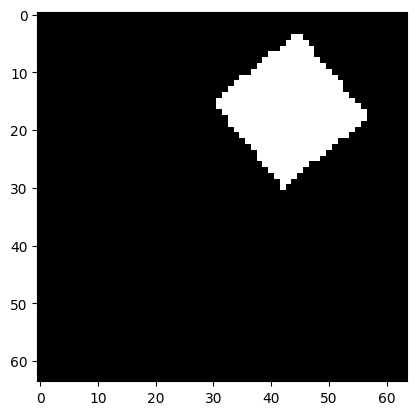

In [79]:
# random_noise = torch.randn(1, 64, 64).cuda()
random_noise = torch.from_numpy(dset[220001][0]).cuda().view(1, 64, 64)
show_tensor(random_noise)

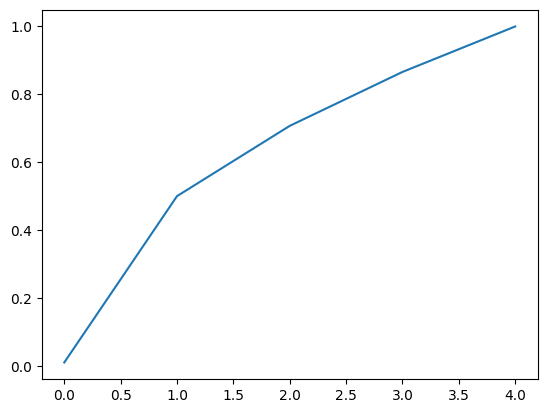

3 tensor(25.1915, device='cuda:0')
2 tensor(26.6547, device='cuda:0')
1 tensor(28.2546, device='cuda:0')
0 tensor(30.8248, device='cuda:0')


In [87]:
var_min, var_max = model.var_min, model.var_max
variance_schedule = np.linspace(0, 1, 5, endpoint=True) * (var_max - var_min) + var_min
plt.figure()
plt.plot(np.sqrt(variance_schedule))
plt.show()

trajectory = torch.empty(len(variance_schedule), 64, 64).cuda()
trajectory[-1, ...] = random_noise.squeeze()
variance_schedule = torch.from_numpy(variance_schedule).cuda()
with torch.no_grad():
    for i in range(len(trajectory) - 2, -1, -1):
        # insert fake batch dimension
        model_score = model(
            x=trajectory[i+1][None, ...],
            compute_loss=False,
            time_steps=torch.tensor(i / len(trajectory)).view(1, 1).cuda()
        ).squeeze()
        print(i, torch.linalg.norm(model_score))
        
        # term_a = (2 - torch.sqrt(1 - variance_schedule[i+1])) * trajectory[i+1]
        # term_b =  variance_schedule[i+1] * model_score
    
        trajectory[i] = trajectory[i+1] + (variance_schedule[i+1] - variance_schedule[i]) * model_score
        added_noise = torch.randn_like(trajectory[i])
        trajectory[i] += added_noise * torch.sqrt(variance_schedule[i+1] - variance_schedule[i])

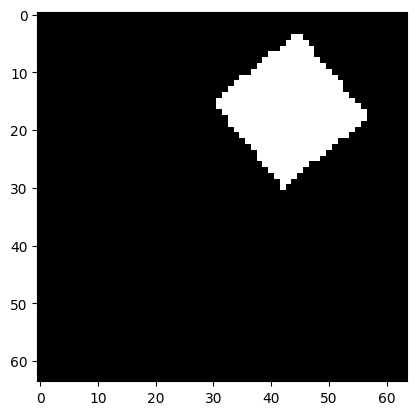

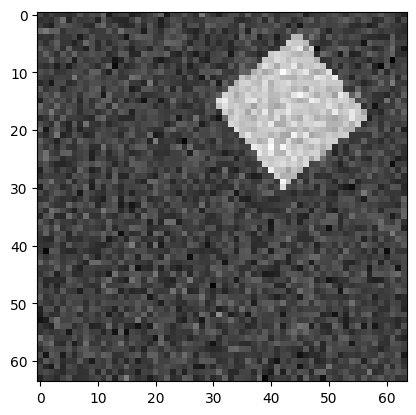

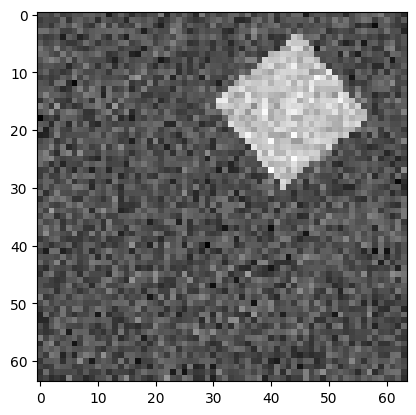

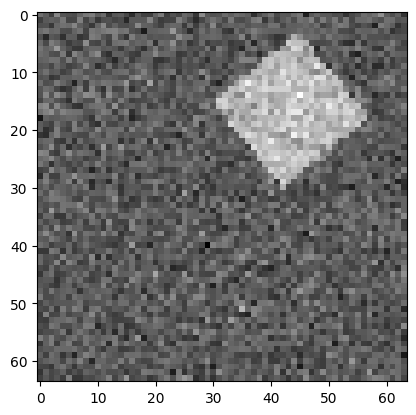

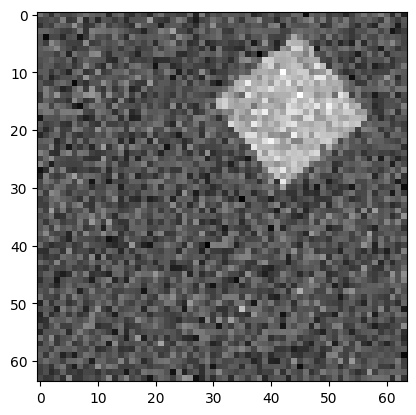

In [88]:
for i in range(len(trajectory) - 1, -1, -1):
    show_tensor(trajectory[i])
